In [1]:
from datetime import datetime, timedelta, timezone
import pandas as pd
from robo_trader import Trader
from robo_trader.feeds import YFinanceFeed
import json
import matplotlib.pyplot as plt

In [2]:
from robo_trader.strategy import Strategy
from robo_trader.portfolio import Portfolio
import ta
import pandas as pd
import numpy as np

class MyStrategy(Strategy):
    def __init__(self):
        super().__init__()

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        data = prices.copy()
        
        cci_upper_threshold = 100
        cci_lower_threshold = -100

        data['cci'] = ta.trend.cci(data['high'], data['low'], data['close'], window=20)
        data['cci_buy'] = data['cci'] < cci_lower_threshold
        data['cci_sell'] = data['cci'] > cci_upper_threshold

        data['macd'] = ta.trend.macd(data['close'], window_fast=12, window_slow=26)
        data['macdsignal'] = ta.trend.macd_signal(data['close'], window_fast=12, window_slow=26, window_sign=9)
        data['macdhist'] = ta.trend.macd_diff(data['close'], window_fast=12, window_slow=26, window_sign=9)
        data['macdhist_last'] = data['macdhist'].shift(1)
        data['macdhist_last2'] = data['macdhist'].shift(2)
        data['macd_buy'] = (data['macdhist'] > data['macdhist_last']) & (data['macdhist_last'] > data['macdhist_last2'])
        data['macd_sell'] = (data['macdhist'] < data['macdhist_last']) & (data['macdhist_last'] < data['macdhist_last2'])

        # Define entry points based on CCI and MACD
        data['long_entry'] = (data['cci_buy']) & (data['macd_buy'])
        
        # Get the last price point
        last_price_point = data.iloc[-1]
        
        # Check for entry signal
        if last_price_point['long_entry']:
            #portfolio.open_long(symbol, .25, take_profit_percentage=.025, stop_percentage=.01)
            portfolio.open_long(symbol, .25, trail_percentage=.025)
        # No need to implement exit logic as we're using trailing stop loss


In [6]:
# SYMBOL = "BTC-GBP"
# train_since = datetime(2016, 7, 1, tzinfo=timezone.utc)
# start_date = datetime(2018, 7, 1, tzinfo=timezone.utc)
# end_date = datetime(2019, 7, 1, tzinfo=timezone.utc)
# interval = Interval.ONE_DAY
# period = 28

#SYMBOL = "BTC-GBP"
SYMBOL = "AAPL"
train_since = pd.to_datetime('2024-01-11').tz_localize('UTC')
start_date = pd.to_datetime('2024-02-11').tz_localize('UTC')
end_date = pd.to_datetime('2024-05-11').tz_localize('UTC')
period = 168

feed = YFinanceFeed(interval = '1h')
strategy = MyStrategy()
trader = Trader(SYMBOL, 1000, feed, strategy)

In [7]:
# Run the backtest
portfolio = trader.backtest(start_date, end_date, period, train_since, transaction_cost=0.004, trailing_stop_penalty_relief=0.9)

Request to open long position on AAPL
    Opening long position for AAPL with for 25.0% of the cash (£250.0)
    Creating MARKET BUY order for AAPL at 183.8000030517578 with quantity 1.354733383382382, trail None, limit None, stop None, take_profit None
    Executing MARKET BUY order for AAPL at 183.8000030517578 with quantity 1.354733383382382, total cost £249.996 and transaction cost £0.996
        Bought 1.354733383382382 AAPL at 183.8000030517578 on 14/02/2024 14:30
    Creating TRAILING_STOP SELL order for AAPL at 183.8000030517578 with quantity 1.354733383382382, trail 0.025, limit None, stop None, take_profit None
Request to open long position on AAPL
    Already long on AAPL
Request to open long position on AAPL
    Already long on AAPL
    Updated trailing stop to 179.42500419616698
Request to open long position on AAPL
    Already long on AAPL
    Updated trailing stop to 179.44499320983886
    Updated trailing stop to 180.3450023651123
    Creating TRAILING_STOP SELL order f

Win Rate: 0.40
Initial Value: 1000.00
Final Value: 993.63
Portfolio Return: -0.0064
Asset Return: -0.0308


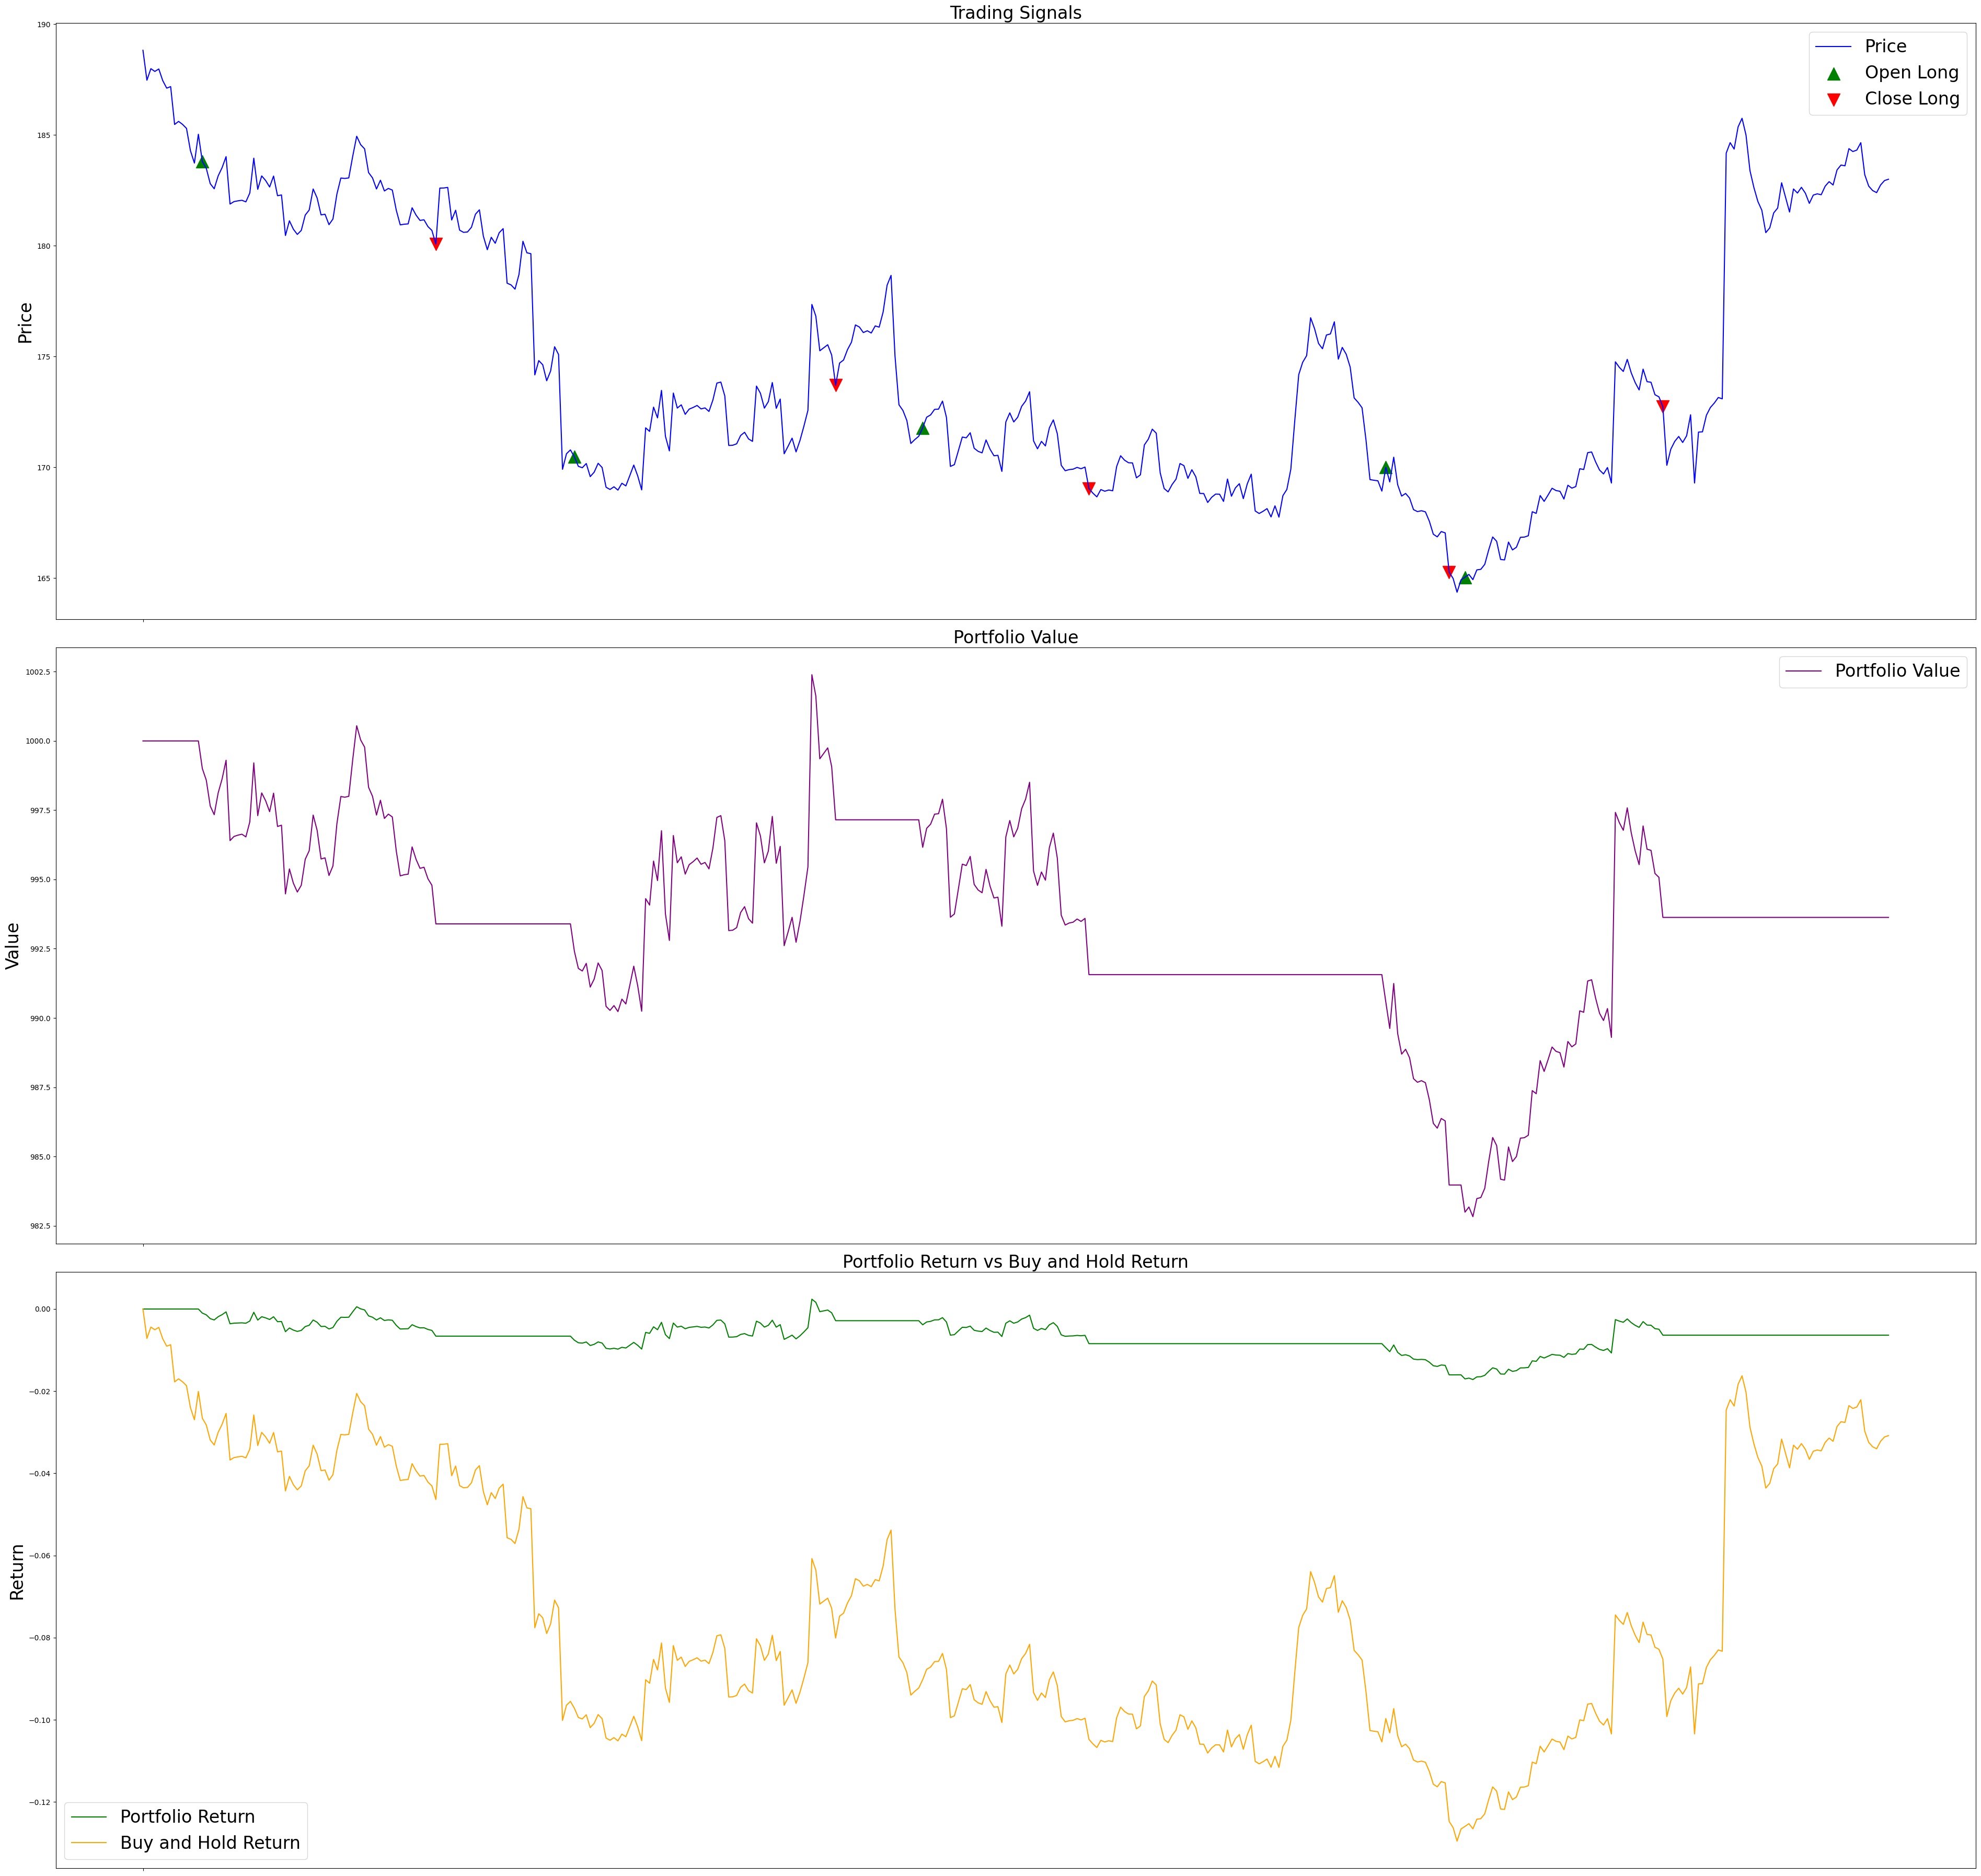

In [8]:
portfolio.plot_performance()